In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import tensorflow as tf

# Pastikan menggunakan session dengan benar jika menggunakan TensorFlow 1.x
sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())


### Import libs

In [3]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import math
import cv2
import copy
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import os

from sklearn.metrics import average_precision_score

from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.objectives import categorical_crossentropy

from keras.models import Model
from keras.utils import generic_utils
from keras.engine import Layer, InputSpec
from keras import initializers, regularizers

Using TensorFlow backend.


In [4]:
from keras import backend as K

# Untuk pelatihan
K.set_learning_phase(1)

#### Config setting

In [5]:
class Config:

	def __init__(self):

		# Print the process or not
		self.verbose = True

		# Name of base network
		self.network = 'vgg'

		# Setting for data augmentation
		self.use_horizontal_flips = False
		self.use_vertical_flips = False
		self.rot_90 = False

		# Anchor box scales
    # Note that if im_size is smaller, anchor_box_scales should be scaled
    # Original anchor_box_scales in the paper is [128, 256, 512]
		self.anchor_box_scales = [64, 128, 256] 

		# Anchor box ratios
		self.anchor_box_ratios = [[1, 1], [1, 1], [1, 1]]

		# Size to resize the smallest side of the image
		# Original setting in paper is 600. Set to 300 in here to save training time
		self.im_size = 300

		# image channel-wise mean to subtract
		self.img_channel_mean = [103.939, 116.779, 123.68]
		self.img_scaling_factor = 1.0

		# number of ROIs at once
		self.num_rois = 4

		# stride at the RPN (this depends on the network configuration)
		self.rpn_stride = 16

		self.balanced_classes = False

		# scaling the stdev
		self.std_scaling = 4.0
		self.classifier_regr_std = [8.0, 8.0, 4.0, 4.0]

		# overlaps for RPN
		self.rpn_min_overlap = 0.3
		self.rpn_max_overlap = 0.7

		# overlaps for classifier ROIs
		self.classifier_min_overlap = 0.1
		self.classifier_max_overlap = 0.5

		# placeholder for the class mapping, automatically generated by the parser
		self.class_mapping = None

		self.model_path = None

#### Parser the data from annotation file

In [6]:
def get_data(input_path):
	"""Parse the data from annotation file
	
	Args:
		input_path: annotation file path

	Returns:
		all_data: list(filepath, width, height, list(bboxes))
		classes_count: dict{key:class_name, value:count_num} 
			e.g. {'Car': 2383, 'Mobile phone': 1108, 'Person': 3745}
		class_mapping: dict{key:class_name, value: idx}
			e.g. {'Car': 0, 'Mobile phone': 1, 'Person': 2}
	"""
	found_bg = False
	all_imgs = {}

	classes_count = {}  

	class_mapping = {}

	visualise = True

	i = 1
	
	with open(input_path,'r') as f:

		print('Parsing annotation files')

		for line in f:

			# Print process
			sys.stdout.write('\r'+'idx=' + str(i))
			i += 1

			line_split = line.strip().split(',')

			# Make sure the info saved in annotation file matching the format (path_filename, x1, y1, x2, y2, class_name)
			# Note:
			#	One path_filename might has several classes (class_name)
			#	x1, y1, x2, y2 are the pixel value of the origial image, not the ratio value
			#	(x1, y1) top left coordinates; (x2, y2) bottom right coordinates
			#   x1,y1-------------------
			#	|						|
			#	|						|
			#	|						|
			#	|						|
			#	---------------------x2,y2

			(filename,x1,y1,x2,y2,class_name) = line_split

			if class_name not in classes_count:
				classes_count[class_name] = 1
			else:
				classes_count[class_name] += 1

			if class_name not in class_mapping:
				if class_name == 'bg' and found_bg == False:
					print('Found class name with special name bg. Will be treated as a background region (this is usually for hard negative mining).')
					found_bg = True
				class_mapping[class_name] = len(class_mapping)

			if filename not in all_imgs:
				all_imgs[filename] = {}
				
				img = cv2.imread(filename)
				(rows,cols) = img.shape[:2]
				all_imgs[filename]['filepath'] = filename
				all_imgs[filename]['width'] = cols
				all_imgs[filename]['height'] = rows
				all_imgs[filename]['bboxes'] = []
				# if np.random.randint(0,6) > 0:
				# 	all_imgs[filename]['imageset'] = 'trainval'
				# else:
				# 	all_imgs[filename]['imageset'] = 'test'

			all_imgs[filename]['bboxes'].append({'class': class_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)})


		all_data = []
		for key in all_imgs:
			all_data.append(all_imgs[key])
		
		# make sure the bg class is last in the list
		if found_bg:
			if class_mapping['bg'] != len(class_mapping) - 1:
				key_to_switch = [key for key in class_mapping.keys() if class_mapping[key] == len(class_mapping)-1][0]
				val_to_switch = class_mapping['bg']
				class_mapping['bg'] = len(class_mapping) - 1
				class_mapping[key_to_switch] = val_to_switch
		
		return all_data, classes_count, class_mapping

#### Define ROI Pooling Convolutional Layer

In [7]:
import tensorflow as tf
from keras import backend as K
from keras.layers import Layer # Keep this import for Keras standalone Layer

class RoiPoolingConv(Layer):
    '''ROI pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_size: int
            Size of pooling region to use. pool_size = 7 will result in a 7x7 region.
        num_rois: number of regions of interest to be used
    # Input shape
        list of two 4D tensors [X_img,X_roi] with shape:
        X_img:
        `(1, rows, cols, channels)`
        X_roi:
        `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
    # Output shape
        3D tensor with shape:
        `(1, num_rois, channels, pool_size, pool_size)`
    '''
    def __init__(self, pool_size, num_rois, **kwargs):
        # --- MODIFIKASI DIMULAI DI SINI ---
        # Hapus baris yang menyebabkan AttributeError:
        # self.dim_ordering = K.image_dim_ordering()

        # Tetapkan dim_ordering secara eksplisit ke 'channels_last'.
        # Ini adalah format standar di Keras/TensorFlow modern dan cocok dengan K.image_data_format() Anda.
        self.dim_ordering = 'channels_last'
        # --- MODIFIKASI BERAKHIR DI SINI ---

        self.pool_size = pool_size
        self.num_rois = num_rois

        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        # 'channels_last' berarti dimensi channel adalah yang terakhir (indeks 3)
        self.nb_channels = input_shape[0][3]

    def compute_output_shape(self, input_shape):
        # Output shape ini (batch, num_rois, pool_size, pool_size, channels)
        # sudah dalam format 'channels_last', jadi tidak perlu perubahan.
        return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):
        assert(len(x) == 2)

        # x[0] is image with shape (rows, cols, channels)
        img = x[0]

        # x[1] is roi with shape (num_rois,4) with ordering (x,y,w,h)
        rois = x[1]

        # input_shape = K.shape(img) # Baris ini tidak langsung digunakan untuk indexing di bawah

        outputs = []

        for roi_idx in range(self.num_rois):
            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]

            x = K.cast(x, 'int32')
            y = K.cast(y, 'int32')
            w = K.cast(w, 'int32')
            h = K.cast(h, 'int32')

            # --- MODIFIKASI DIMULAI DI SINI ---
            # tf.image.resize_images telah diganti namanya di TF2.x menjadi tf.image.resize.
            # Meskipun Anda menggunakan TF 1.15, fungsi ini lebih konsisten dan aman.
            cropped_img = img[:, y:y+h, x:x+w, :]
            rs = tf.image.resize(cropped_img, (self.pool_size, self.pool_size))
            # --- MODIFIKASI BERAKHIR DI SINI ---

            outputs.append(rs)

        final_output = K.concatenate(outputs, axis=0)

        # Reshape to (1, num_rois, pool_size, pool_size, nb_channels)
        # Ini sudah benar untuk 'channels_last'.
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))

        # K.permute_dimensions(final_output, (0, 1, 2, 3, 4)) tidak mengubah urutan dimensi.
        # Anda bisa mempertahankannya jika ingin eksplisit, atau menghapusnya jika tidak ada efek.
        # Jika Anda ingin output channels-first (..., channels, height, width), Anda akan menggunakan (0, 1, 4, 2, 3).
        final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output

    def get_config(self):
        config = {'pool_size': self.pool_size,
                  'num_rois': self.num_rois}
        base_config = super(RoiPoolingConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

#### Vgg-16 model

In [8]:
def get_img_output_length(width, height):
    def get_output_length(input_length):
        return input_length//16

    return get_output_length(width), get_output_length(height)    

def nn_base(input_tensor=None, trainable=False):


    input_shape = (None, None, 3)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    # x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    return x

####  RPN layer

In [9]:
def rpn_layer(base_layers, num_anchors):
    """Create a rpn layer
        Step1: Pass through the feature map from base layer to a 3x3 512 channels convolutional layer
                Keep the padding 'same' to preserve the feature map's size
        Step2: Pass the step1 to two (1,1) convolutional layer to replace the fully connected layer
                classification layer: num_anchors (9 in here) channels for 0, 1 sigmoid activation output
                regression layer: num_anchors*4 (36 in here) channels for computing the regression of bboxes with linear activation
    Args:
        base_layers: vgg in here
        num_anchors: 9 in here

    Returns:
        [x_class, x_regr, base_layers]
        x_class: classification for whether it's an object
        x_regr: bboxes regression
        base_layers: vgg in here
    """
    x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)

    x_class = Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)

    return [x_class, x_regr, base_layers]

####  Classifier layer

In [10]:
def classifier_layer(base_layers, input_rois, num_rois, nb_classes = 4):
    """Create a classifier layer
    
    Args:
        base_layers: vgg
        input_rois: `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
        num_rois: number of rois to be processed in one time (4 in here)

    Returns:
        list(out_class, out_regr)
        out_class: classifier layer output
        out_regr: regression layer output
    """

    input_shape = (num_rois,7,7,512)

    pooling_regions = 7

    # out_roi_pool.shape = (1, num_rois, channels, pool_size, pool_size)
    # num_rois (4) 7x7 roi pooling
    out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])

    # Flatten the convlutional layer and connected to 2 FC and 2 dropout
    out = TimeDistributed(Flatten(name='flatten'))(out_roi_pool)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc1'))(out)
    out = TimeDistributed(Dropout(0.5))(out)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc2'))(out)
    out = TimeDistributed(Dropout(0.5))(out)

    # There are two output layer
    # out_class: softmax acivation function for classify the class name of the object
    # out_regr: linear activation function for bboxes coordinates regression
    out_class = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes))(out)
    # note: no regression target for bg class
    out_regr = TimeDistributed(Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes))(out)

    return [out_class, out_regr]

#### Calculate IoU (Intersection of Union)

In [11]:
def union(au, bu, area_intersection):
	area_a = (au[2] - au[0]) * (au[3] - au[1])
	area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
	area_union = area_a + area_b - area_intersection
	return area_union


def intersection(ai, bi):
	x = max(ai[0], bi[0])
	y = max(ai[1], bi[1])
	w = min(ai[2], bi[2]) - x
	h = min(ai[3], bi[3]) - y
	if w < 0 or h < 0:
		return 0
	return w*h


def iou(a, b):
	# a and b should be (x1,y1,x2,y2)

	if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
		return 0.0

	area_i = intersection(a, b)
	area_u = union(a, b, area_i)

	return float(area_i) / float(area_u + 1e-6)

#### Calculate the rpn for all anchors of all images

In [12]:
def calc_rpn(C, img_data, width, height, resized_width, resized_height, img_length_calc_function):
	"""(Important part!) Calculate the rpn for all anchors 
		If feature map has shape 38x50=1900, there are 1900x9=17100 potential anchors
	
	Args:
		C: config
		img_data: augmented image data
		width: original image width (e.g. 600)
		height: original image height (e.g. 800)
		resized_width: resized image width according to C.im_size (e.g. 300)
		resized_height: resized image height according to C.im_size (e.g. 400)
		img_length_calc_function: function to calculate final layer's feature map (of base model) size according to input image size

	Returns:
		y_rpn_cls: list(num_bboxes, y_is_box_valid + y_rpn_overlap)
			y_is_box_valid: 0 or 1 (0 means the box is invalid, 1 means the box is valid)
			y_rpn_overlap: 0 or 1 (0 means the box is not an object, 1 means the box is an object)
		y_rpn_regr: list(num_bboxes, 4*y_rpn_overlap + y_rpn_regr)
			y_rpn_regr: x1,y1,x2,y2 bunding boxes coordinates
	"""
	downscale = float(C.rpn_stride) 
	anchor_sizes = C.anchor_box_scales   # 128, 256, 512
	anchor_ratios = C.anchor_box_ratios  # 1:1, 1:2*sqrt(2), 2*sqrt(2):1
	num_anchors = len(anchor_sizes) * len(anchor_ratios) # 3x3=9

	# calculate the output map size based on the network architecture
	(output_width, output_height) = img_length_calc_function(resized_width, resized_height)

	n_anchratios = len(anchor_ratios)    # 3
	
	# initialise empty output objectives
	y_rpn_overlap = np.zeros((output_height, output_width, num_anchors))
	y_is_box_valid = np.zeros((output_height, output_width, num_anchors))
	y_rpn_regr = np.zeros((output_height, output_width, num_anchors * 4))

	num_bboxes = len(img_data['bboxes'])

	num_anchors_for_bbox = np.zeros(num_bboxes).astype(int)
	best_anchor_for_bbox = -1*np.ones((num_bboxes, 4)).astype(int)
	best_iou_for_bbox = np.zeros(num_bboxes).astype(np.float32)
	best_x_for_bbox = np.zeros((num_bboxes, 4)).astype(int)
	best_dx_for_bbox = np.zeros((num_bboxes, 4)).astype(np.float32)

	# get the GT box coordinates, and resize to account for image resizing
	gta = np.zeros((num_bboxes, 4))
	for bbox_num, bbox in enumerate(img_data['bboxes']):
		# get the GT box coordinates, and resize to account for image resizing
		gta[bbox_num, 0] = bbox['x1'] * (resized_width / float(width))
		gta[bbox_num, 1] = bbox['x2'] * (resized_width / float(width))
		gta[bbox_num, 2] = bbox['y1'] * (resized_height / float(height))
		gta[bbox_num, 3] = bbox['y2'] * (resized_height / float(height))
	
	# rpn ground truth

	for anchor_size_idx in range(len(anchor_sizes)):
		for anchor_ratio_idx in range(n_anchratios):
			anchor_x = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][0]
			anchor_y = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][1]	
			
			for ix in range(output_width):					
				# x-coordinates of the current anchor box	
				x1_anc = downscale * (ix + 0.5) - anchor_x / 2
				x2_anc = downscale * (ix + 0.5) + anchor_x / 2	
				
				# ignore boxes that go across image boundaries					
				if x1_anc < 0 or x2_anc > resized_width:
					continue
					
				for jy in range(output_height):

					# y-coordinates of the current anchor box
					y1_anc = downscale * (jy + 0.5) - anchor_y / 2
					y2_anc = downscale * (jy + 0.5) + anchor_y / 2

					# ignore boxes that go across image boundaries
					if y1_anc < 0 or y2_anc > resized_height:
						continue

					# bbox_type indicates whether an anchor should be a target
					# Initialize with 'negative'
					bbox_type = 'neg'

					# this is the best IOU for the (x,y) coord and the current anchor
					# note that this is different from the best IOU for a GT bbox
					best_iou_for_loc = 0.0

					for bbox_num in range(num_bboxes):
						
						# get IOU of the current GT box and the current anchor box
						curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1_anc, y1_anc, x2_anc, y2_anc])
						# calculate the regression targets if they will be needed
						if curr_iou > best_iou_for_bbox[bbox_num] or curr_iou > C.rpn_max_overlap:
							cx = (gta[bbox_num, 0] + gta[bbox_num, 1]) / 2.0
							cy = (gta[bbox_num, 2] + gta[bbox_num, 3]) / 2.0
							cxa = (x1_anc + x2_anc)/2.0
							cya = (y1_anc + y2_anc)/2.0

							# x,y are the center point of ground-truth bbox
							# xa,ya are the center point of anchor bbox (xa=downscale * (ix + 0.5); ya=downscale * (iy+0.5))
							# w,h are the width and height of ground-truth bbox
							# wa,ha are the width and height of anchor bboxe
							# tx = (x - xa) / wa
							# ty = (y - ya) / ha
							# tw = log(w / wa)
							# th = log(h / ha)
							tx = (cx - cxa) / (x2_anc - x1_anc)
							ty = (cy - cya) / (y2_anc - y1_anc)
							tw = np.log((gta[bbox_num, 1] - gta[bbox_num, 0]) / (x2_anc - x1_anc))
							th = np.log((gta[bbox_num, 3] - gta[bbox_num, 2]) / (y2_anc - y1_anc))
						
						if img_data['bboxes'][bbox_num]['class'] != 'bg':

							# all GT boxes should be mapped to an anchor box, so we keep track of which anchor box was best
							if curr_iou > best_iou_for_bbox[bbox_num]:
								best_anchor_for_bbox[bbox_num] = [jy, ix, anchor_ratio_idx, anchor_size_idx]
								best_iou_for_bbox[bbox_num] = curr_iou
								best_x_for_bbox[bbox_num,:] = [x1_anc, x2_anc, y1_anc, y2_anc]
								best_dx_for_bbox[bbox_num,:] = [tx, ty, tw, th]

							# we set the anchor to positive if the IOU is >0.7 (it does not matter if there was another better box, it just indicates overlap)
							if curr_iou > C.rpn_max_overlap:
								bbox_type = 'pos'
								num_anchors_for_bbox[bbox_num] += 1
								# we update the regression layer target if this IOU is the best for the current (x,y) and anchor position
								if curr_iou > best_iou_for_loc:
									best_iou_for_loc = curr_iou
									best_regr = (tx, ty, tw, th)

							# if the IOU is >0.3 and <0.7, it is ambiguous and no included in the objective
							if C.rpn_min_overlap < curr_iou < C.rpn_max_overlap:
								# gray zone between neg and pos
								if bbox_type != 'pos':
									bbox_type = 'neutral'

					# turn on or off outputs depending on IOUs
					if bbox_type == 'neg':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
					elif bbox_type == 'neutral':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
					elif bbox_type == 'pos':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						start = 4 * (anchor_ratio_idx + n_anchratios * anchor_size_idx)
						y_rpn_regr[jy, ix, start:start+4] = best_regr

	# we ensure that every bbox has at least one positive RPN region

	for idx in range(num_anchors_for_bbox.shape[0]):
		if num_anchors_for_bbox[idx] == 0:
			# no box with an IOU greater than zero ...
			if best_anchor_for_bbox[idx, 0] == -1:
				continue
			y_is_box_valid[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
				best_anchor_for_bbox[idx,3]] = 1
			y_rpn_overlap[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
				best_anchor_for_bbox[idx,3]] = 1
			start = 4 * (best_anchor_for_bbox[idx,2] + n_anchratios * best_anchor_for_bbox[idx,3])
			y_rpn_regr[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], start:start+4] = best_dx_for_bbox[idx, :]

	y_rpn_overlap = np.transpose(y_rpn_overlap, (2, 0, 1))
	y_rpn_overlap = np.expand_dims(y_rpn_overlap, axis=0)

	y_is_box_valid = np.transpose(y_is_box_valid, (2, 0, 1))
	y_is_box_valid = np.expand_dims(y_is_box_valid, axis=0)

	y_rpn_regr = np.transpose(y_rpn_regr, (2, 0, 1))
	y_rpn_regr = np.expand_dims(y_rpn_regr, axis=0)

	pos_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 1, y_is_box_valid[0, :, :, :] == 1))
	neg_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 0, y_is_box_valid[0, :, :, :] == 1))

	num_pos = len(pos_locs[0])

	# one issue is that the RPN has many more negative than positive regions, so we turn off some of the negative
	# regions. We also limit it to 256 regions.
	num_regions = 256

	if len(pos_locs[0]) > num_regions/2:
		val_locs = random.sample(range(len(pos_locs[0])), len(pos_locs[0]) - num_regions/2)
		y_is_box_valid[0, pos_locs[0][val_locs], pos_locs[1][val_locs], pos_locs[2][val_locs]] = 0
		num_pos = num_regions/2

	if len(neg_locs[0]) + num_pos > num_regions:
		val_locs = random.sample(range(len(neg_locs[0])), len(neg_locs[0]) - num_pos)
		y_is_box_valid[0, neg_locs[0][val_locs], neg_locs[1][val_locs], neg_locs[2][val_locs]] = 0

	y_rpn_cls = np.concatenate([y_is_box_valid, y_rpn_overlap], axis=1)
	y_rpn_regr = np.concatenate([np.repeat(y_rpn_overlap, 4, axis=1), y_rpn_regr], axis=1)

	return np.copy(y_rpn_cls), np.copy(y_rpn_regr), num_pos

#### Get new image size and augment the image

In [13]:
def get_new_img_size(width, height, img_min_side=300):
	if width <= height:
		f = float(img_min_side) / width
		resized_height = int(f * height)
		resized_width = img_min_side
	else:
		f = float(img_min_side) / height
		resized_width = int(f * width)
		resized_height = img_min_side

	return resized_width, resized_height

def augment(img_data, config, augment=True):
	assert 'filepath' in img_data
	assert 'bboxes' in img_data
	assert 'width' in img_data
	assert 'height' in img_data

	img_data_aug = copy.deepcopy(img_data)

	img = cv2.imread(img_data_aug['filepath'])

	if augment:
		rows, cols = img.shape[:2]

		if config.use_horizontal_flips and np.random.randint(0, 2) == 0:
			img = cv2.flip(img, 1)
			for bbox in img_data_aug['bboxes']:
				x1 = bbox['x1']
				x2 = bbox['x2']
				bbox['x2'] = cols - x1
				bbox['x1'] = cols - x2

		if config.use_vertical_flips and np.random.randint(0, 2) == 0:
			img = cv2.flip(img, 0)
			for bbox in img_data_aug['bboxes']:
				y1 = bbox['y1']
				y2 = bbox['y2']
				bbox['y2'] = rows - y1
				bbox['y1'] = rows - y2

		if config.rot_90:
			angle = np.random.choice([0,90,180,270],1)[0]
			if angle == 270:
				img = np.transpose(img, (1,0,2))
				img = cv2.flip(img, 0)
			elif angle == 180:
				img = cv2.flip(img, -1)
			elif angle == 90:
				img = np.transpose(img, (1,0,2))
				img = cv2.flip(img, 1)
			elif angle == 0:
				pass

			for bbox in img_data_aug['bboxes']:
				x1 = bbox['x1']
				x2 = bbox['x2']
				y1 = bbox['y1']
				y2 = bbox['y2']
				if angle == 270:
					bbox['x1'] = y1
					bbox['x2'] = y2
					bbox['y1'] = cols - x2
					bbox['y2'] = cols - x1
				elif angle == 180:
					bbox['x2'] = cols - x1
					bbox['x1'] = cols - x2
					bbox['y2'] = rows - y1
					bbox['y1'] = rows - y2
				elif angle == 90:
					bbox['x1'] = rows - y2
					bbox['x2'] = rows - y1
					bbox['y1'] = x1
					bbox['y2'] = x2        
				elif angle == 0:
					pass

	img_data_aug['width'] = img.shape[1]
	img_data_aug['height'] = img.shape[0]
	return img_data_aug, img

#### Generate the ground_truth anchors

In [14]:
def get_anchor_gt(all_img_data, C, img_length_calc_function, mode='train'):
	""" Yield the ground-truth anchors as Y (labels)

	Args:
		all_img_data: list(filepath, width, height, list(bboxes))
		C: config
		img_length_calc_function: function to calculate final layer's feature map (of base model) size according to input image size
		mode: 'train' or 'test'; 'train' mode need augmentation

	Returns:
		x_img: image data after resized and scaling (smallest size = 300px)
		Y: [y_rpn_cls, y_rpn_regr]
		img_data_aug: augmented image data (original image with augmentation)
		debug_img: show image for debug
		num_pos: show number of positive anchors for debug
	"""
	while True:

		for img_data in all_img_data:
			try:

				# read in image, and optionally add augmentation

				if mode == 'train':
					img_data_aug, x_img = augment(img_data, C, augment=True)
				else:
					img_data_aug, x_img = augment(img_data, C, augment=False)

				(width, height) = (img_data_aug['width'], img_data_aug['height'])
				(rows, cols, _) = x_img.shape

				assert cols == width
				assert rows == height

				# get image dimensions for resizing
				(resized_width, resized_height) = get_new_img_size(width, height, C.im_size)

				# resize the image so that smalles side is length = 300px
				x_img = cv2.resize(x_img, (resized_width, resized_height), interpolation=cv2.INTER_CUBIC)
				debug_img = x_img.copy()

				try:
					y_rpn_cls, y_rpn_regr, num_pos = calc_rpn(C, img_data_aug, width, height, resized_width, resized_height, img_length_calc_function)
				except:
					continue

				# Zero-center by mean pixel, and preprocess image

				x_img = x_img[:,:, (2, 1, 0)]  # BGR -> RGB
				x_img = x_img.astype(np.float32)
				x_img[:, :, 0] -= C.img_channel_mean[0]
				x_img[:, :, 1] -= C.img_channel_mean[1]
				x_img[:, :, 2] -= C.img_channel_mean[2]
				x_img /= C.img_scaling_factor

				x_img = np.transpose(x_img, (2, 0, 1))
				x_img = np.expand_dims(x_img, axis=0)

				y_rpn_regr[:, y_rpn_regr.shape[1]//2:, :, :] *= C.std_scaling

				x_img = np.transpose(x_img, (0, 2, 3, 1))
				y_rpn_cls = np.transpose(y_rpn_cls, (0, 2, 3, 1))
				y_rpn_regr = np.transpose(y_rpn_regr, (0, 2, 3, 1))

				yield np.copy(x_img), [np.copy(y_rpn_cls), np.copy(y_rpn_regr)], img_data_aug, debug_img, num_pos

			except Exception as e:
				print(e)
				continue

#### Define loss functions for all four outputs

In [15]:
lambda_rpn_regr = 1.0
lambda_rpn_class = 1.0

lambda_cls_regr = 1.0
lambda_cls_class = 1.0

epsilon = 1e-4

In [16]:
def rpn_loss_regr(num_anchors):
    """Loss function for rpn regression
    Args:
        num_anchors: number of anchors (9 in here)
    Returns:
        Smooth L1 loss function 
                           0.5*x*x (if x_abs < 1)
                           x_abx - 0.5 (otherwise)
    """
    def rpn_loss_regr_fixed_num(y_true, y_pred):

        # x is the difference between true value and predicted vaue
        x = y_true[:, :, :, 4 * num_anchors:] - y_pred

        # absolute value of x
        x_abs = K.abs(x)

        # If x_abs <= 1.0, x_bool = 1
        x_bool = K.cast(K.less_equal(x_abs, 1.0), tf.float32)

        return lambda_rpn_regr * K.sum(
            y_true[:, :, :, :4 * num_anchors] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :, :4 * num_anchors])

    return rpn_loss_regr_fixed_num


def rpn_loss_cls(num_anchors):
    """Loss function for rpn classification
    Args:
        num_anchors: number of anchors (9 in here)
        y_true[:, :, :, :9]: [0,1,0,0,0,0,0,1,0] means only the second and the eighth box is valid which contains pos or neg anchor => isValid
        y_true[:, :, :, 9:]: [0,1,0,0,0,0,0,0,0] means the second box is pos and eighth box is negative
    Returns:
        lambda * sum((binary_crossentropy(isValid*y_pred,y_true))) / N
    """
    def rpn_loss_cls_fixed_num(y_true, y_pred):

            return lambda_rpn_class * K.sum(y_true[:, :, :, :num_anchors] * K.binary_crossentropy(y_pred[:, :, :, :], y_true[:, :, :, num_anchors:])) / K.sum(epsilon + y_true[:, :, :, :num_anchors])

    return rpn_loss_cls_fixed_num


def class_loss_regr(num_classes):
    """Loss function for rpn regression
    Args:
        num_anchors: number of anchors (9 in here)
    Returns:
        Smooth L1 loss function 
                           0.5*x*x (if x_abs < 1)
                           x_abx - 0.5 (otherwise)
    """
    def class_loss_regr_fixed_num(y_true, y_pred):
        x = y_true[:, :, 4*num_classes:] - y_pred
        x_abs = K.abs(x)
        x_bool = K.cast(K.less_equal(x_abs, 1.0), 'float32')
        return lambda_cls_regr * K.sum(y_true[:, :, :4*num_classes] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :4*num_classes])
    return class_loss_regr_fixed_num


def class_loss_cls(y_true, y_pred):
    return lambda_cls_class * K.mean(categorical_crossentropy(y_true[0, :, :], y_pred[0, :, :]))

In [17]:
def non_max_suppression_fast(boxes, probs, overlap_thresh=0.9, max_boxes=300):
    # code used from here: http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
    # if there are no boxes, return an empty list

    # Process explanation:
    #   Step 1: Sort the probs list
    #   Step 2: Find the larget prob 'Last' in the list and save it to the pick list
    #   Step 3: Calculate the IoU with 'Last' box and other boxes in the list. If the IoU is larger than overlap_threshold, delete the box from list
    #   Step 4: Repeat step 2 and step 3 until there is no item in the probs list 
    if len(boxes) == 0:
        return []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    np.testing.assert_array_less(x1, x2)
    np.testing.assert_array_less(y1, y2)

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []

    # calculate the areas
    area = (x2 - x1) * (y2 - y1)

    # sort the bounding boxes 
    idxs = np.argsort(probs)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the intersection

        xx1_int = np.maximum(x1[i], x1[idxs[:last]])
        yy1_int = np.maximum(y1[i], y1[idxs[:last]])
        xx2_int = np.minimum(x2[i], x2[idxs[:last]])
        yy2_int = np.minimum(y2[i], y2[idxs[:last]])

        ww_int = np.maximum(0, xx2_int - xx1_int)
        hh_int = np.maximum(0, yy2_int - yy1_int)

        area_int = ww_int * hh_int

        # find the union
        area_union = area[i] + area[idxs[:last]] - area_int

        # compute the ratio of overlap
        overlap = area_int/(area_union + 1e-6)

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlap_thresh)[0])))

        if len(pick) >= max_boxes:
            break

    # return only the bounding boxes that were picked using the integer data type
    boxes = boxes[pick].astype("int")
    probs = probs[pick]
    return boxes, probs

def apply_regr_np(X, T):
    """Apply regression layer to all anchors in one feature map

    Args:
        X: shape=(4, 18, 25) the current anchor type for all points in the feature map
        T: regression layer shape=(4, 18, 25)

    Returns:
        X: regressed position and size for current anchor
    """
    try:
        x = X[0, :, :]
        y = X[1, :, :]
        w = X[2, :, :]
        h = X[3, :, :]

        tx = T[0, :, :]
        ty = T[1, :, :]
        tw = T[2, :, :]
        th = T[3, :, :]

        cx = x + w/2.
        cy = y + h/2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy

        w1 = np.exp(tw.astype(np.float64)) * w
        h1 = np.exp(th.astype(np.float64)) * h
        x1 = cx1 - w1/2.
        y1 = cy1 - h1/2.

        x1 = np.round(x1)
        y1 = np.round(y1)
        w1 = np.round(w1)
        h1 = np.round(h1)
        return np.stack([x1, y1, w1, h1])
    except Exception as e:
        print(e)
        return X
    
def apply_regr(x, y, w, h, tx, ty, tw, th):
    # Apply regression to x, y, w and h
    try:
        cx = x + w/2.
        cy = y + h/2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy
        w1 = math.exp(tw) * w
        h1 = math.exp(th) * h
        x1 = cx1 - w1/2.
        y1 = cy1 - h1/2.
        x1 = int(round(x1))
        y1 = int(round(y1))
        w1 = int(round(w1))
        h1 = int(round(h1))

        return x1, y1, w1, h1

    except ValueError:
        return x, y, w, h
    except OverflowError:
        return x, y, w, h
    except Exception as e:
        print(e)
        return x, y, w, h

def calc_iou(R, img_data, C, class_mapping):
    """Converts from (x1,y1,x2,y2) to (x,y,w,h) format

    Args:
        R: bboxes, probs
    """
    bboxes = img_data['bboxes']
    (width, height) = (img_data['width'], img_data['height'])
    # get image dimensions for resizing
    (resized_width, resized_height) = get_new_img_size(width, height, C.im_size)

    gta = np.zeros((len(bboxes), 4))

    for bbox_num, bbox in enumerate(bboxes):
        # get the GT box coordinates, and resize to account for image resizing
        # gta[bbox_num, 0] = (40 * (600 / 800)) / 16 = int(round(1.875)) = 2 (x in feature map)
        gta[bbox_num, 0] = int(round(bbox['x1'] * (resized_width / float(width))/C.rpn_stride))
        gta[bbox_num, 1] = int(round(bbox['x2'] * (resized_width / float(width))/C.rpn_stride))
        gta[bbox_num, 2] = int(round(bbox['y1'] * (resized_height / float(height))/C.rpn_stride))
        gta[bbox_num, 3] = int(round(bbox['y2'] * (resized_height / float(height))/C.rpn_stride))

    x_roi = []
    y_class_num = []
    y_class_regr_coords = []
    y_class_regr_label = []
    IoUs = [] # for debugging only

    # R.shape[0]: number of bboxes (=300 from non_max_suppression)
    for ix in range(R.shape[0]):
        (x1, y1, x2, y2) = R[ix, :]
        x1 = int(round(x1))
        y1 = int(round(y1))
        x2 = int(round(x2))
        y2 = int(round(y2))

        best_iou = 0.0
        best_bbox = -1
        # Iterate through all the ground-truth bboxes to calculate the iou
        for bbox_num in range(len(bboxes)):
            curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1, y1, x2, y2])

            # Find out the corresponding ground-truth bbox_num with larget iou
            if curr_iou > best_iou:
                best_iou = curr_iou
                best_bbox = bbox_num

        if best_iou < C.classifier_min_overlap:
                continue
        else:
            w = x2 - x1
            h = y2 - y1
            x_roi.append([x1, y1, w, h])
            IoUs.append(best_iou)

            if C.classifier_min_overlap <= best_iou < C.classifier_max_overlap:
                # hard negative example
                cls_name = 'bg'
            elif C.classifier_max_overlap <= best_iou:
                cls_name = bboxes[best_bbox]['class']
                cxg = (gta[best_bbox, 0] + gta[best_bbox, 1]) / 2.0
                cyg = (gta[best_bbox, 2] + gta[best_bbox, 3]) / 2.0

                cx = x1 + w / 2.0
                cy = y1 + h / 2.0

                tx = (cxg - cx) / float(w)
                ty = (cyg - cy) / float(h)
                tw = np.log((gta[best_bbox, 1] - gta[best_bbox, 0]) / float(w))
                th = np.log((gta[best_bbox, 3] - gta[best_bbox, 2]) / float(h))
            else:
                print('roi = {}'.format(best_iou))
                raise RuntimeError

        class_num = class_mapping[cls_name]
        class_label = len(class_mapping) * [0]
        class_label[class_num] = 1
        y_class_num.append(copy.deepcopy(class_label))
        coords = [0] * 4 * (len(class_mapping) - 1)
        labels = [0] * 4 * (len(class_mapping) - 1)
        if cls_name != 'bg':
            label_pos = 4 * class_num
            sx, sy, sw, sh = C.classifier_regr_std
            coords[label_pos:4+label_pos] = [sx*tx, sy*ty, sw*tw, sh*th]
            labels[label_pos:4+label_pos] = [1, 1, 1, 1]
            y_class_regr_coords.append(copy.deepcopy(coords))
            y_class_regr_label.append(copy.deepcopy(labels))
        else:
            y_class_regr_coords.append(copy.deepcopy(coords))
            y_class_regr_label.append(copy.deepcopy(labels))

    if len(x_roi) == 0:
        return None, None, None, None

    # bboxes that iou > C.classifier_min_overlap for all gt bboxes in 300 non_max_suppression bboxes
    X = np.array(x_roi)
    # one hot code for bboxes from above => x_roi (X)
    Y1 = np.array(y_class_num)
    # corresponding labels and corresponding gt bboxes
    Y2 = np.concatenate([np.array(y_class_regr_label),np.array(y_class_regr_coords)],axis=1)

    return np.expand_dims(X, axis=0), np.expand_dims(Y1, axis=0), np.expand_dims(Y2, axis=0), IoUs

In [18]:
def rpn_to_roi(rpn_layer, regr_layer, C, dim_ordering, use_regr=True, max_boxes=300,overlap_thresh=0.9):
	"""Convert rpn layer to roi bboxes

	Args: (num_anchors = 9)
		rpn_layer: output layer for rpn classification 
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 18) if resized image is 400 width and 300
		regr_layer: output layer for rpn regression
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 72) if resized image is 400 width and 300
		C: config
		use_regr: Wether to use bboxes regression in rpn
		max_boxes: max bboxes number for non-max-suppression (NMS)
		overlap_thresh: If iou in NMS is larger than this threshold, drop the box

	Returns:
		result: boxes from non-max-suppression (shape=(300, 4))
			boxes: coordinates for bboxes (on the feature map)
	"""
	regr_layer = regr_layer / C.std_scaling

	anchor_sizes = C.anchor_box_scales   # (3 in here)
	anchor_ratios = C.anchor_box_ratios  # (3 in here)

	assert rpn_layer.shape[0] == 1

	(rows, cols) = rpn_layer.shape[1:3]

	curr_layer = 0

	# A.shape = (4, feature_map.height, feature_map.width, num_anchors) 
	# Might be (4, 18, 25, 18) if resized image is 400 width and 300
	# A is the coordinates for 9 anchors for every point in the feature map 
	# => all 18x25x9=4050 anchors cooridnates
	A = np.zeros((4, rpn_layer.shape[1], rpn_layer.shape[2], rpn_layer.shape[3]))

	for anchor_size in anchor_sizes:
		for anchor_ratio in anchor_ratios:
			# anchor_x = (128 * 1) / 16 = 8  => width of current anchor
			# anchor_y = (128 * 2) / 16 = 16 => height of current anchor
			anchor_x = (anchor_size * anchor_ratio[0])/C.rpn_stride
			anchor_y = (anchor_size * anchor_ratio[1])/C.rpn_stride
			
			# curr_layer: 0~8 (9 anchors)
			# the Kth anchor of all position in the feature map (9th in total)
			regr = regr_layer[0, :, :, 4 * curr_layer:4 * curr_layer + 4] # shape => (18, 25, 4)
			regr = np.transpose(regr, (2, 0, 1)) # shape => (4, 18, 25)

			# Create 18x25 mesh grid
			# For every point in x, there are all the y points and vice versa
			# X.shape = (18, 25)
			# Y.shape = (18, 25)
			X, Y = np.meshgrid(np.arange(cols),np. arange(rows))

			# Calculate anchor position and size for each feature map point
			A[0, :, :, curr_layer] = X - anchor_x/2 # Top left x coordinate
			A[1, :, :, curr_layer] = Y - anchor_y/2 # Top left y coordinate
			A[2, :, :, curr_layer] = anchor_x       # width of current anchor
			A[3, :, :, curr_layer] = anchor_y       # height of current anchor

			# Apply regression to x, y, w and h if there is rpn regression layer
			if use_regr:
				A[:, :, :, curr_layer] = apply_regr_np(A[:, :, :, curr_layer], regr)

			# Avoid width and height exceeding 1
			A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])

			# Convert (x, y , w, h) to (x1, y1, x2, y2)
			# x1, y1 is top left coordinate
			# x2, y2 is bottom right coordinate
			A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
			A[3, :, :, curr_layer] += A[1, :, :, curr_layer]

			# Avoid bboxes drawn outside the feature map
			A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
			A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
			A[2, :, :, curr_layer] = np.minimum(cols-1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.minimum(rows-1, A[3, :, :, curr_layer])

			curr_layer += 1

	all_boxes = np.reshape(A.transpose((0, 3, 1, 2)), (4, -1)).transpose((1, 0))  # shape=(4050, 4)
	all_probs = rpn_layer.transpose((0, 3, 1, 2)).reshape((-1))                   # shape=(4050,)

	x1 = all_boxes[:, 0]
	y1 = all_boxes[:, 1]
	x2 = all_boxes[:, 2]
	y2 = all_boxes[:, 3]

	# Find out the bboxes which is illegal and delete them from bboxes list
	idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))

	all_boxes = np.delete(all_boxes, idxs, 0)
	all_probs = np.delete(all_probs, idxs, 0)

	# Apply non_max_suppression
	# Only extract the bboxes. Don't need rpn probs in the later process
	result = non_max_suppression_fast(all_boxes, all_probs, overlap_thresh=overlap_thresh, max_boxes=max_boxes)[0]

	return result



---





---



### Start training

In [19]:
base_path = r'C:\Users\Lenovo\Documents\TA-2025-01\\'


train_path =  r'train annotation_normalized4.txt'

num_rois = 4 # Number of RoIs to process at once.

# Augmentation flag
horizontal_flips = False # Augment with horizontal flips in training. 
vertical_flips = False # Augment with vertical flips in training. 
rot_90 = False           # Augment with 90 degree rotations in training. 

output_weight_path = os.path.join(base_path, 'model_frcnn_vgg.hdf5')

record_path = os.path.join(base_path, 'record.csv') # Record data (used to save the losses, classification accuracy and mean average precision)

base_weight_path = r'C:/Users/Lenovo/Documents/Penelitian/FasterRCNN/dataset - Copy/vgg16_weights_tf_dim_ordering_tf_kernels.h5'

config_output_filename = os.path.join(base_path, 'model_vgg_config.pickle')

In [20]:
import os
print(os.path.exists(base_weight_path ))  # Harusnya True jika file ada


True


In [21]:
# Create the config
C = Config()



C.record_path = record_path
C.model_path = output_weight_path
C.num_rois = num_rois

C.base_net_weights = base_weight_path

In [22]:
#--------------------------------------------------------#
# This step will spend some time to load the data        #
#--------------------------------------------------------#
st = time.time()
train_imgs, classes_count, class_mapping = get_data(train_path)
print()
print('Spend %0.2f mins to load the data' % ((time.time()-st)/60) )

Parsing annotation files
idx=1759
Spend 0.11 mins to load the data


In [23]:
if 'bg' not in classes_count:
	classes_count['bg'] = 0
	class_mapping['bg'] = len(class_mapping)
# e.g.
#    classes_count: {'Car': 2383, 'Mobile phone': 1108, 'Person': 3745, 'bg': 0}
#    class_mapping: {'Person': 0, 'Car': 1, 'Mobile phone': 2, 'bg': 3}
C.class_mapping = class_mapping

print('Training images per class:')
pprint.pprint(classes_count)
print('Num classes (including bg) = {}'.format(len(classes_count)))
print(class_mapping)

# Save the configuration
with open(config_output_filename, 'wb') as config_f:
	pickle.dump(C,config_f)
	print('Config has been written to {}, and can be loaded when testing to ensure correct results'.format(config_output_filename))


Training images per class:
{'Mobil': 1759, 'bg': 0}
Num classes (including bg) = 2
{'Mobil': 0, 'bg': 1}
Config has been written to C:\Users\Lenovo\Documents\TA-2025-01\\model_vgg_config.pickle, and can be loaded when testing to ensure correct results


In [24]:
# Shuffle the images with seed
random.seed(1)
random.shuffle(train_imgs)

print('Num train samples (images) {}'.format(len(train_imgs)))

Num train samples (images) 1546


In [25]:
# Get train data generator which generate X, Y, image_data
data_gen_train = get_anchor_gt(train_imgs, C, get_img_output_length, mode='train')

#### Explore 'data_gen_train'

data_gen_train is an **generator**, so we get the data by calling **next(data_gen_train)**

In [26]:
X, Y, image_data, debug_img, debug_num_pos = next(data_gen_train)

Original image: height=281 width=578
Resized image:  height=300 width=617 C.im_size=300
Feature map size: height=18 width=38 C.rpn_stride=16
(1, 300, 617, 3)
2 includes 'y_rpn_cls' and 'y_rpn_regr'
Shape of y_rpn_cls (1, 18, 38, 18)
Shape of y_rpn_regr (1, 18, 38, 72)
{'filepath': 'C:\\Users\\Lenovo\\Documents\\TA-2025-01\\Data_set\\train\\0cbbb07fb43240f79a92c6cf021dbcba_jpg.rf.ce2584eb7da42abeeb2671107fa83f71.jpg', 'width': 578, 'height': 281, 'bboxes': [{'class': 'Mobil', 'x1': 29, 'x2': 554, 'y1': 34, 'y2': 280}]}
Number of positive anchors for this image: 1
(array([10, 10, 10], dtype=int64), array([10, 10, 10], dtype=int64), array([ 5,  6, 15], dtype=int64))
(array([10, 10, 10, 10], dtype=int64), array([10, 10, 10, 10], dtype=int64), array([24, 25, 26, 27], dtype=int64))
y_rpn_cls for possible pos anchor: [0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
y_rpn_regr for positive anchor: [ 0.          0.          0.          0.          0.          0.
  0.          0.         

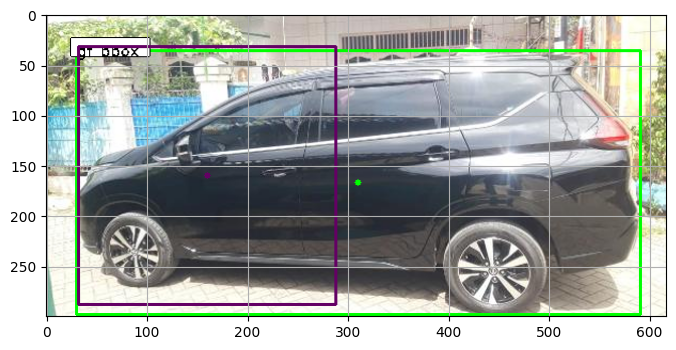

In [27]:
print('Original image: height=%d width=%d'%(image_data['height'], image_data['width']))
print('Resized image:  height=%d width=%d C.im_size=%d'%(X.shape[1], X.shape[2], C.im_size))
print('Feature map size: height=%d width=%d C.rpn_stride=%d'%(Y[0].shape[1], Y[0].shape[2], C.rpn_stride))
print(X.shape)
print(str(len(Y))+" includes 'y_rpn_cls' and 'y_rpn_regr'")
print('Shape of y_rpn_cls {}'.format(Y[0].shape))
print('Shape of y_rpn_regr {}'.format(Y[1].shape))
print(image_data)

print('Number of positive anchors for this image: %d' % (debug_num_pos))
if debug_num_pos==0:
    gt_x1, gt_x2 = image_data['bboxes'][0]['x1']*(X.shape[2]/image_data['height']), image_data['bboxes'][0]['x2']*(X.shape[2]/image_data['height'])
    gt_y1, gt_y2 = image_data['bboxes'][0]['y1']*(X.shape[1]/image_data['width']), image_data['bboxes'][0]['y2']*(X.shape[1]/image_data['width'])
    gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)

    img = debug_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color = (0, 255, 0)
    cv2.putText(img, 'gt bbox', (gt_x1, gt_y1-5), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
    cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
    cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)

    plt.grid()
    plt.imshow(img)
    plt.show()
else:
    cls = Y[0][0]
    pos_cls = np.where(cls==1)
    print(pos_cls)
    regr = Y[1][0]
    pos_regr = np.where(regr==1)
    print(pos_regr)
    print('y_rpn_cls for possible pos anchor: {}'.format(cls[pos_cls[0][0],pos_cls[1][0],:]))
    print('y_rpn_regr for positive anchor: {}'.format(regr[pos_regr[0][0],pos_regr[1][0],:]))

    gt_x1, gt_x2 = image_data['bboxes'][0]['x1']*(X.shape[2]/image_data['width']), image_data['bboxes'][0]['x2']*(X.shape[2]/image_data['width'])
    gt_y1, gt_y2 = image_data['bboxes'][0]['y1']*(X.shape[1]/image_data['height']), image_data['bboxes'][0]['y2']*(X.shape[1]/image_data['height'])
    gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)

    img = debug_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color = (0, 255, 0)
    #   cv2.putText(img, 'gt bbox', (gt_x1, gt_y1-5), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
    cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
    cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)

    # Add text
    textLabel = 'gt bbox'
    (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,0.5,1)
    textOrg = (gt_x1, gt_y1+5)
    cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 2)
    cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
    cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 0, 0), 1)

    # Draw positive anchors according to the y_rpn_regr
    for i in range(debug_num_pos):

        color = (100+i*(155/4), 0, 100+i*(155/4))

        idx = pos_regr[2][i*4]/4
        anchor_size = C.anchor_box_scales[int(idx/3)]
        anchor_ratio = C.anchor_box_ratios[2-int((idx+1)%3)]

        center = (pos_regr[1][i*4]*C.rpn_stride, pos_regr[0][i*4]*C.rpn_stride)
        print('Center position of positive anchor: ', center)
        cv2.circle(img, center, 3, color, -1)
        anc_w, anc_h = anchor_size*anchor_ratio[0], anchor_size*anchor_ratio[1]
        cv2.rectangle(img, (center[0]-int(anc_w/2), center[1]-int(anc_h/2)), (center[0]+int(anc_w/2), center[1]+int(anc_h/2)), color, 2)
#         cv2.putText(img, 'pos anchor bbox '+str(i+1), (center[0]-int(anc_w/2), center[1]-int(anc_h/2)-5), cv2.FONT_HERSHEY_DUPLEX, 0.5, color, 1)

print('Green bboxes is ground-truth bbox. Others are positive anchors')
plt.figure(figsize=(8,8))
plt.grid()
plt.imshow(img)
plt.show()

#### Build the model

In [28]:
input_shape_img = (None, None, 3)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(None, 4))

# define the base network (VGG here, can be Resnet50, Inception, etc)
shared_layers = nn_base(img_input, trainable=True)

In [29]:
# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios) # 9

rpn = rpn_layer(shared_layers, num_anchors)

classifier = classifier_layer(shared_layers, roi_input, C.num_rois, nb_classes=len(classes_count))

model_rpn = Model(img_input, rpn[:2])
model_classifier = Model([img_input, roi_input], classifier)

# this is a model that holds both the RPN and the classifier, used to load/save weights for the models
model_all = Model([img_input, roi_input], rpn[:2] + classifier)

# Because the google colab can only run the session several hours one time (then you need to connect again), 
# we need to save the model and load the model to continue training
if not os.path.isfile(C.model_path):
    #If this is the begin of the training, load the pre-traind base network such as vgg-16
    try:
        print('This is the first time of your training')
        print('loading weights from {}'.format(C.base_net_weights))
        model_rpn.load_weights(C.base_net_weights, by_name=True)
        model_classifier.load_weights(C.base_net_weights, by_name=True)
    except  Exception as e:
        print(f'Error loading weights: {e}')
        print('Could not load pretrained model weights. Weights can be found in the keras application folder \
            https://github.com/fchollet/keras/tree/master/keras/applications')
    
    # Create the record.csv file to record losses, acc and mAP
    record_df = pd.DataFrame(columns=['mean_overlapping_bboxes', 'class_acc', 'loss_rpn_cls', 'loss_rpn_regr', 'loss_class_cls', 'loss_class_regr', 'curr_loss', 'elapsed_time', 'mAP'])
else:
    # If this is a continued training, load the trained model from before
    print('Continue training based on previous trained model')
    print('Loading weights from {}'.format(C.model_path))
    model_rpn.load_weights(C.model_path, by_name=True)
    model_classifier.load_weights(C.model_path, by_name=True)
    
    # Load the records
    record_df = pd.read_csv(record_path)

    r_mean_overlapping_bboxes = record_df['mean_overlapping_bboxes']
    r_class_acc = record_df['class_acc']
    r_loss_rpn_cls = record_df['loss_rpn_cls']
    r_loss_rpn_regr = record_df['loss_rpn_regr']
    r_loss_class_cls = record_df['loss_class_cls']
    r_loss_class_regr = record_df['loss_class_regr']
    r_curr_loss = record_df['curr_loss']
    r_elapsed_time = record_df['elapsed_time']
    r_mAP = record_df['mAP']

    print('Already train %dK batches'% (len(record_df)))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
This is the first time of your training
loading weights from C:/Users/Lenovo/Documents/Penelitian/FasterRCNN/dataset - Copy/vgg16_weights_tf_dim_ordering_tf_kernels.h5








In [30]:
import os

weights_path = 'C:/Users/Lenovo/Documents/Penelitian/FasterRCNN/dataset - Copy/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
print(os.path.exists(weights_path))


True


In [31]:
optimizer = Adam(lr=1e-5)  # Optimizer Adam dengan learning rate kecil (1e-5) untuk model RPN
optimizer_classifier = Adam(lr=1e-5)  # Optimizer Adam untuk model classifier (head RCNN)

# Kompilasi model RPN dengan dua jenis loss:
# - rpn_loss_cls: untuk klasifikasi anchor (objek atau background)
# - rpn_loss_regr: untuk regresi (penyesuaian posisi anchor ke ground truth)
model_rpn.compile(
    optimizer=optimizer,
    loss=[rpn_loss_cls(num_anchors), rpn_loss_regr(num_anchors)]
)

# Kompilasi model classifier (RCNN head) dengan dua jenis loss:
# - class_loss_cls: klasifikasi objek sebenarnya
# - class_loss_regr: regresi bbox akhir
# Ditambah metrik akurasi untuk layer klasifikasi (dense_class_X)
model_classifier.compile(
    optimizer=optimizer_classifier,
    loss=[
        class_loss_cls,
        class_loss_regr(len(classes_count)-1)  # jumlah kelas dikurangi 1 (tanpa background)
    ],
    metrics={'dense_class_{}'.format(len(classes_count)): 'accuracy'}  # metrik akurasi untuk layer klasifikasi
)

# Kompilasi model gabungan (RPN + Classifier) hanya untuk kebutuhan training loss total (misal untuk resume training)
# Menggunakan SGD dan Mean Absolute Error sebagai loss placeholder
model_all.compile(
    optimizer='sgd',
    loss='mae'
)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [32]:
# Training settings

total_epochs = len(record_df)         # Total epoch saat ini berdasarkan jumlah baris dalam DataFrame record_df
r_epochs = len(record_df)             # Salinan dari total_epochs untuk keperluan rekaman atau pelacakan ulang

epoch_length = 32                     # Jumlah iterasi per epoch
num_epochs = 400                      # Jumlah epoch yang akan dilatih ke depan
iter_num = 0                          # Inisialisasi penghitung iterasi

total_epochs += num_epochs           # Total epoch diperbarui dengan menambahkan jumlah epoch baru

losses = np.zeros((epoch_length, 5)) # Matriks kosong untuk menyimpan loss selama epoch_length; 5 jenis loss yang dicatat
rpn_accuracy_rpn_monitor = []        # List untuk memonitor akurasi RPN per iterasi (untuk keperluan log atau debug)
rpn_accuracy_for_epoch = []          # List untuk menyimpan akurasi RPN per epoch

if len(record_df) == 0:
    best_loss = np.Inf               # Jika tidak ada data sebelumnya, set best_loss ke tak hingga (akan digantikan jika loss baru lebih kecil)
else:
    best_loss = np.min(r_curr_loss)  # Jika ada data sebelumnya, ambil nilai minimum dari r_curr_loss sebagai best_loss awal


In [33]:
print(len(record_df))
K.set_learning_phase(1) 

0


In [34]:
from keras import backend as K

# Untuk pelatihan
K.set_learning_phase(1)


In [35]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


In [36]:
import keras
import tensorflow as tf

keras.backend.set_session(tf.Session())
keras.backend.get_session().run(tf.global_variables_initializer())


In [37]:
start_time = time.time()
for epoch_num in range(num_epochs):

    progbar = generic_utils.Progbar(epoch_length)
    print('Epoch {}/{}'.format(r_epochs + 1, total_epochs))
    
    r_epochs += 1

    while True:
        try:

            if len(rpn_accuracy_rpn_monitor) == epoch_length and C.verbose:
                mean_overlapping_bboxes = float(sum(rpn_accuracy_rpn_monitor))/len(rpn_accuracy_rpn_monitor)
                rpn_accuracy_rpn_monitor = []
#                 print('Average number of overlapping bounding boxes from RPN = {} for {} previous iterations'.format(mean_overlapping_bboxes, epoch_length))
                if mean_overlapping_bboxes == 0:
                    print('RPN is not producing bounding boxes that overlap the ground truth boxes. Check RPN settings or keep training.')

            # Generate X (x_img) and label Y ([y_rpn_cls, y_rpn_regr])
            X, Y, img_data, debug_img, debug_num_pos = next(data_gen_train)

            # Train rpn model and get loss value [_, loss_rpn_cls, loss_rpn_regr]
            loss_rpn = model_rpn.train_on_batch(X, Y)

            # Get predicted rpn from rpn model [rpn_cls, rpn_regr]
            P_rpn = model_rpn.predict_on_batch(X)

            # R: bboxes (shape=(300,4))
            # Convert rpn layer to roi bboxes
            R = rpn_to_roi(P_rpn[0], P_rpn[1], C, 'channels_last', use_regr=True, overlap_thresh=0.7, max_boxes=300)
            
            # note: calc_iou converts from (x1,y1,x2,y2) to (x,y,w,h) format
            # X2: bboxes that iou > C.classifier_min_overlap for all gt bboxes in 300 non_max_suppression bboxes
            # Y1: one hot code for bboxes from above => x_roi (X)
            # Y2: corresponding labels and corresponding gt bboxes
            X2, Y1, Y2, IouS = calc_iou(R, img_data, C, class_mapping)

            # If X2 is None means there are no matching bboxes
            if X2 is None:
                rpn_accuracy_rpn_monitor.append(0)
                rpn_accuracy_for_epoch.append(0)
                continue
            
            # Find out the positive anchors and negative anchors
            neg_samples = np.where(Y1[0, :, -1] == 1)
            pos_samples = np.where(Y1[0, :, -1] == 0)

            if len(neg_samples) > 0:
                neg_samples = neg_samples[0]
            else:
                neg_samples = []

            if len(pos_samples) > 0:
                pos_samples = pos_samples[0]
            else:
                pos_samples = []

            rpn_accuracy_rpn_monitor.append(len(pos_samples))
            rpn_accuracy_for_epoch.append((len(pos_samples)))

            if C.num_rois > 1:
                # If number of positive anchors is larger than 4//2 = 2, randomly choose 2 pos samples
                if len(pos_samples) < C.num_rois//2:
                    selected_pos_samples = pos_samples.tolist()
                else:
                    selected_pos_samples = np.random.choice(pos_samples, C.num_rois//2, replace=False).tolist()
                
                # Randomly choose (num_rois - num_pos) neg samples
                try:
                    selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=False).tolist()
                except:
                    selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=True).tolist()
                
                # Save all the pos and neg samples in sel_samples
                sel_samples = selected_pos_samples + selected_neg_samples
            else:
                # in the extreme case where num_rois = 1, we pick a random pos or neg sample
                selected_pos_samples = pos_samples.tolist()
                selected_neg_samples = neg_samples.tolist()
                if np.random.randint(0, 2):
                    sel_samples = random.choice(neg_samples)
                else:
                    sel_samples = random.choice(pos_samples)

            # training_data: [X, X2[:, sel_samples, :]]
            # labels: [Y1[:, sel_samples, :], Y2[:, sel_samples, :]]
            #  X                     => img_data resized image
            #  X2[:, sel_samples, :] => num_rois (4 in here) bboxes which contains selected neg and pos
            #  Y1[:, sel_samples, :] => one hot encode for num_rois bboxes which contains selected neg and pos
            #  Y2[:, sel_samples, :] => labels and gt bboxes for num_rois bboxes which contains selected neg and pos
            loss_class = model_classifier.train_on_batch([X, X2[:, sel_samples, :]], [Y1[:, sel_samples, :], Y2[:, sel_samples, :]])

            losses[iter_num, 0] = loss_rpn[1]
            losses[iter_num, 1] = loss_rpn[2]

            losses[iter_num, 2] = loss_class[1]
            losses[iter_num, 3] = loss_class[2]
            losses[iter_num, 4] = loss_class[3]

            iter_num += 1

            progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])),
                                      ('final_cls', np.mean(losses[:iter_num, 2])), ('final_regr', np.mean(losses[:iter_num, 3]))])

            if iter_num == epoch_length:
                loss_rpn_cls = np.mean(losses[:, 0])
                loss_rpn_regr = np.mean(losses[:, 1])
                loss_class_cls = np.mean(losses[:, 2])
                loss_class_regr = np.mean(losses[:, 3])
                class_acc = np.mean(losses[:, 4])

                mean_overlapping_bboxes = float(sum(rpn_accuracy_for_epoch)) / len(rpn_accuracy_for_epoch)
                rpn_accuracy_for_epoch = []

                if C.verbose:
                    print('Mean number of bounding boxes from RPN overlapping ground truth boxes: {}'.format(mean_overlapping_bboxes))
                    print('Classifier accuracy for bounding boxes from RPN: {}'.format(class_acc))
                    print('Loss RPN classifier: {}'.format(loss_rpn_cls))
                    print('Loss RPN regression: {}'.format(loss_rpn_regr))
                    print('Loss Detector classifier: {}'.format(loss_class_cls))
                    print('Loss Detector regression: {}'.format(loss_class_regr))
                    print('Total loss: {}'.format(loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr))
                    print('Elapsed time: {}'.format(time.time() - start_time))
                    elapsed_time = (time.time()-start_time)/60

                curr_loss = loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr
                iter_num = 0
                start_time = time.time()

                if curr_loss < best_loss:
                    if C.verbose:
                        print('Total loss decreased from {} to {}, saving weights'.format(best_loss,curr_loss))
                    best_loss = curr_loss
                    model_all.save_weights(C.model_path)

                new_row = {'mean_overlapping_bboxes':round(mean_overlapping_bboxes, 3), 
                           'class_acc':round(class_acc, 3), 
                           'loss_rpn_cls':round(loss_rpn_cls, 3), 
                           'loss_rpn_regr':round(loss_rpn_regr, 3), 
                           'loss_class_cls':round(loss_class_cls, 3), 
                           'loss_class_regr':round(loss_class_regr, 3), 
                           'curr_loss':round(curr_loss, 3), 
                           'elapsed_time':round(elapsed_time, 3), 
                           'mAP': 0}

                record_df = record_df.append(new_row, ignore_index=True)
                record_df.to_csv(record_path, index=0)

                break

        except Exception as e:
            print('Exception: {}'.format(e))
            continue

print('Training complete, exiting.')

Epoch 1/400


32/32 [==============================] - 419s 13s/step - rpn_cls: 3.9740 - rpn_regr: 0.2557 - final_cls: 0.6944 - final_regr: 0.4843
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.5
Classifier accuracy for bounding boxes from RPN: 0.5078125
Loss RPN classifier: 1.8573917020716308
Loss RPN regression: 0.26680042408406734
Loss Detector classifier: 0.6973665300756693
Loss Detector regression: 0.46994656743481755
Total loss: 3.291505223666185
Elapsed time: 419.428893327713
Total loss decreased from inf to 3.291505223666185, saving weights
Epoch 2/400
32/32 [==============================] - 426s 13s/step - rpn_cls: 0.2969 - rpn_regr: 0.2113 - final_cls: 0.6911 - final_regr: 0.4356
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.65625
Classifier accuracy for bounding boxes from RPN: 0.5390625
Loss RPN classifier: 0.3527405121761831
Loss RPN regression: 0.2541167251765728
Loss Detector classifier: 0.694924371317029
Loss Detecto

32/32 [==============================] - 413s 13s/step - rpn_cls: 0.4706 - rpn_regr: 0.2066 - final_cls: 0.3754 - final_regr: 0.3478
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.5
Classifier accuracy for bounding boxes from RPN: 0.828125
Loss RPN classifier: 0.3816872917178853
Loss RPN regression: 0.21685866577900015
Loss Detector classifier: 0.3955911295488477
Loss Detector regression: 0.33494890737347305
Total loss: 1.3290859944192062
Elapsed time: 412.9243619441986
Epoch 17/400
32/32 [==============================] - 420s 13s/step - rpn_cls: 0.4698 - rpn_regr: 0.2285 - final_cls: 0.3588 - final_regr: 0.3255
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.5
Classifier accuracy for bounding boxes from RPN: 0.875
Loss RPN classifier: 0.22507762519209984
Loss RPN regression: 0.20231736118148547
Loss Detector classifier: 0.38590206793742254
Loss Detector regression: 0.30609484389424324
Total loss: 1.119391898205251
Elapsed time: 419.6

32/32 [==============================] - 424s 13s/step - rpn_cls: 0.0119 - rpn_regr: 0.1735 - final_cls: 0.3318 - final_regr: 0.2927
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.25
Classifier accuracy for bounding boxes from RPN: 0.8515625
Loss RPN classifier: 0.022730376813191455
Loss RPN regression: 0.1769111502217129
Loss Detector classifier: 0.35591889219358563
Loss Detector regression: 0.2980167919304222
Total loss: 0.8535772111589122
Elapsed time: 423.7522304058075
Total loss decreased from 0.9832566169145238 to 0.8535772111589122, saving weights
Epoch 33/400
32/32 [==============================] - 407s 13s/step - rpn_cls: 0.6220 - rpn_regr: 0.2052 - final_cls: 0.3214 - final_regr: 0.3104
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.125
Classifier accuracy for bounding boxes from RPN: 0.8828125
Loss RPN classifier: 0.555987214356725
Loss RPN regression: 0.21289844196871854
Loss Detector classifier: 0.2876866737497039
Loss D

32/32 [==============================] - 424s 13s/step - rpn_cls: 0.3927 - rpn_regr: 0.1921 - final_cls: 0.6670 - final_regr: 0.2973
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.34375
Classifier accuracy for bounding boxes from RPN: 0.8125
Loss RPN classifier: 0.3986026094430517
Loss RPN regression: 0.2123323876876384
Loss Detector classifier: 0.49906194023787975
Loss Detector regression: 0.3255881618242711
Total loss: 1.435585099192841
Elapsed time: 423.79186630249023
Epoch 49/400
32/32 [==============================] - 416s 13s/step - rpn_cls: 0.8089 - rpn_regr: 0.2833 - final_cls: 0.2259 - final_regr: 0.2666
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.125
Classifier accuracy for bounding boxes from RPN: 0.890625
Loss RPN classifier: 0.5940610765626149
Loss RPN regression: 0.24641626834636554
Loss Detector classifier: 0.24356661178171635
Loss Detector regression: 0.2757010629866272
Total loss: 1.359745019677324
Elapsed time: 4

32/32 [==============================] - 411s 13s/step - rpn_cls: 0.5411 - rpn_regr: 0.2084 - final_cls: 0.2999 - final_regr: 0.2381
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.21875
Classifier accuracy for bounding boxes from RPN: 0.84375
Loss RPN classifier: 0.4970852699335646
Loss RPN regression: 0.19453874957980588
Loss Detector classifier: 0.34519502584589645
Loss Detector regression: 0.22015707893297076
Total loss: 1.2569761242922377
Elapsed time: 410.87406492233276
Epoch 65/400
32/32 [==============================] - 425s 13s/step - rpn_cls: 0.1843 - rpn_regr: 0.2112 - final_cls: 0.2242 - final_regr: 0.2934
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.3125
Classifier accuracy for bounding boxes from RPN: 0.90625
Loss RPN classifier: 0.218395472901314
Loss RPN regression: 0.2001029515377013
Loss Detector classifier: 0.22118099877843633
Loss Detector regression: 0.25049841892905533
Total loss: 0.890177842146507
Elapsed time

32/32 [==============================] - 432s 14s/step - rpn_cls: 0.3323 - rpn_regr: 0.1503 - final_cls: 0.4814 - final_regr: 0.2658
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.25
Classifier accuracy for bounding boxes from RPN: 0.875
Loss RPN classifier: 0.18765021120223313
Loss RPN regression: 0.18234848690917715
Loss Detector classifier: 0.38889124762499705
Loss Detector regression: 0.26802914193831384
Total loss: 1.0269190876747212
Elapsed time: 432.2834622859955
Epoch 81/400
32/32 [==============================] - 399s 12s/step - rpn_cls: 0.2318 - rpn_regr: 0.1594 - final_cls: 0.4363 - final_regr: 0.2664
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.0625
Classifier accuracy for bounding boxes from RPN: 0.8046875
Loss RPN classifier: 0.3535008343899937
Loss RPN regression: 0.17470622347900644
Loss Detector classifier: 0.3760570934973657
Loss Detector regression: 0.2666381844319403
Total loss: 1.1709023357983062
Elapsed time: 

32/32 [==============================] - 421s 13s/step - rpn_cls: 0.1529 - rpn_regr: 0.1926 - final_cls: 0.3647 - final_regr: 0.2027
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.28125
Classifier accuracy for bounding boxes from RPN: 0.8828125
Loss RPN classifier: 0.3897579901249868
Loss RPN regression: 0.1955298311659135
Loss Detector classifier: 0.37490753654856235
Loss Detector regression: 0.224475848255679
Total loss: 1.1846712060951416
Elapsed time: 421.32324147224426
Epoch 97/400
32/32 [==============================] - 438s 14s/step - rpn_cls: 0.2781 - rpn_regr: 0.2225 - final_cls: 0.3590 - final_regr: 0.2055
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.75
Classifier accuracy for bounding boxes from RPN: 0.8125
Loss RPN classifier: 0.5751699392474721
Loss RPN regression: 0.22899166878778487
Loss Detector classifier: 0.38888818863779306
Loss Detector regression: 0.22560039767995477
Total loss: 1.4186501943530048
Elapsed time:

32/32 [==============================] - 400s 13s/step - rpn_cls: 0.5677 - rpn_regr: 0.1639 - final_cls: 0.3868 - final_regr: 0.2395
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.96875
Classifier accuracy for bounding boxes from RPN: 0.8203125
Loss RPN classifier: 0.5678011155275156
Loss RPN regression: 0.18220049898081925
Loss Detector classifier: 0.4694922809721902
Loss Detector regression: 0.24641713500022888
Total loss: 1.4659110304807539
Elapsed time: 400.3866751194
Epoch 113/400
32/32 [==============================] - 431s 13s/step - rpn_cls: 0.3637 - rpn_regr: 0.1709 - final_cls: 0.3647 - final_regr: 0.2163
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.625
Classifier accuracy for bounding boxes from RPN: 0.890625
Loss RPN classifier: 0.35738074103038686
Loss RPN regression: 0.18135753128444776
Loss Detector classifier: 0.33612133911810815
Loss Detector regression: 0.20986988273216411
Total loss: 1.0847294941651069
Elapsed ti

32/32 [==============================] - 437s 14s/step - rpn_cls: 0.7622 - rpn_regr: 0.1598 - final_cls: 0.2619 - final_regr: 0.2442
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.3125
Classifier accuracy for bounding boxes from RPN: 0.84375
Loss RPN classifier: 0.4339303155980674
Loss RPN regression: 0.15081311273388565
Loss Detector classifier: 0.33090732723940164
Loss Detector regression: 0.235843961534556
Total loss: 1.1514947171059107
Elapsed time: 437.4986181259155
Epoch 129/400
32/32 [==============================] - 406s 13s/step - rpn_cls: 0.0765 - rpn_regr: 0.1713 - final_cls: 0.4371 - final_regr: 0.2831
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.4375
Classifier accuracy for bounding boxes from RPN: 0.8515625
Loss RPN classifier: 0.1501878194429882
Loss RPN regression: 0.16986316454131156
Loss Detector classifier: 0.3151386978570372
Loss Detector regression: 0.23096005141269416
Total loss: 0.8661497332540311
Elapsed tim

32/32 [==============================] - 435s 14s/step - rpn_cls: 0.5085 - rpn_regr: 0.2106 - final_cls: 0.2715 - final_regr: 0.2457
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.5625
Classifier accuracy for bounding boxes from RPN: 0.8984375
Loss RPN classifier: 0.5676074859515123
Loss RPN regression: 0.20628409524215385
Loss Detector classifier: 0.28507137997075915
Loss Detector regression: 0.23430543462745845
Total loss: 1.2932683957918838
Elapsed time: 434.92376804351807
Epoch 145/400
32/32 [==============================] - 432s 13s/step - rpn_cls: 0.4290 - rpn_regr: 0.2031 - final_cls: 0.2638 - final_regr: 0.1948
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.125
Classifier accuracy for bounding boxes from RPN: 0.859375
Loss RPN classifier: 0.39361650671135595
Loss RPN regression: 0.19475608982611448
Loss Detector classifier: 0.31826247880235314
Loss Detector regression: 0.18859786889515817
Total loss: 1.0952329442349817
Elapse

32/32 [==============================] - 399s 12s/step - rpn_cls: 1.2532 - rpn_regr: 0.2264 - final_cls: 0.3438 - final_regr: 0.2803
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.5
Classifier accuracy for bounding boxes from RPN: 0.890625
Loss RPN classifier: 0.9192210466848427
Loss RPN regression: 0.1718076218967326
Loss Detector classifier: 0.3393904612166807
Loss Detector regression: 0.24279655958525836
Total loss: 1.6732156893835144
Elapsed time: 399.3721146583557
Epoch 161/400
32/32 [==============================] - 410s 13s/step - rpn_cls: 0.5764 - rpn_regr: 0.2128 - final_cls: 0.3373 - final_regr: 0.2433
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.34375
Classifier accuracy for bounding boxes from RPN: 0.8671875
Loss RPN classifier: 0.38360905563553716
Loss RPN regression: 0.19280715464265086
Loss Detector classifier: 0.3780662801582366
Loss Detector regression: 0.23481083987280726
Total loss: 1.189293330309232
Elapsed time

32/32 [==============================] - 420s 13s/step - rpn_cls: 0.3384 - rpn_regr: 0.1347 - final_cls: 0.3266 - final_regr: 0.2305
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.78125
Classifier accuracy for bounding boxes from RPN: 0.859375
Loss RPN classifier: 0.4636313966023573
Loss RPN regression: 0.13256738873315044
Loss Detector classifier: 0.3136843216198031
Loss Detector regression: 0.2049310333095491
Total loss: 1.11481414026486
Elapsed time: 419.880175113678
Epoch 177/400
32/32 [==============================] - 417s 13s/step - rpn_cls: 0.0070 - rpn_regr: 0.1292 - final_cls: 0.4754 - final_regr: 0.1860
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.625
Classifier accuracy for bounding boxes from RPN: 0.84375
Loss RPN classifier: 0.12323574307634999
Loss RPN regression: 0.1469003422971582
Loss Detector classifier: 0.4060851689428091
Loss Detector regression: 0.21206608810462058
Total loss: 0.8882873424209379
Elapsed time: 4

32/32 [==============================] - 435s 14s/step - rpn_cls: 0.2045 - rpn_regr: 0.1994 - final_cls: 0.4640 - final_regr: 0.2089
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.84375
Classifier accuracy for bounding boxes from RPN: 0.890625
Loss RPN classifier: 0.32177738937088685
Loss RPN regression: 0.20602115569636226
Loss Detector classifier: 0.3582859322777949
Loss Detector regression: 0.1975582049926743
Total loss: 1.0836426823377183
Elapsed time: 434.55976009368896
Epoch 193/400
32/32 [==============================] - 426s 13s/step - rpn_cls: 0.4600 - rpn_regr: 0.1540 - final_cls: 0.2380 - final_regr: 0.2464
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.1875
Classifier accuracy for bounding boxes from RPN: 0.9296875
Loss RPN classifier: 0.39115799155526987
Loss RPN regression: 0.1553015809331555
Loss Detector classifier: 0.2790263929637149
Loss Detector regression: 0.21330698591191322
Total loss: 1.0387929513640535
Elapsed

32/32 [==============================] - 414s 13s/step - rpn_cls: 0.6495 - rpn_regr: 0.1178 - final_cls: 0.2685 - final_regr: 0.1409
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.8125
Classifier accuracy for bounding boxes from RPN: 0.90625
Loss RPN classifier: 1.0052402987530156
Loss RPN regression: 0.14194549596868455
Loss Detector classifier: 0.2630602486024145
Loss Detector regression: 0.1404123194515705
Total loss: 1.5506583627756851
Elapsed time: 413.9807643890381
Epoch 209/400
32/32 [==============================] - 410s 13s/step - rpn_cls: 0.2263 - rpn_regr: 0.1532 - final_cls: 0.3702 - final_regr: 0.2382
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.0625
Classifier accuracy for bounding boxes from RPN: 0.828125
Loss RPN classifier: 0.3770227600186935
Loss RPN regression: 0.1621823156310711
Loss Detector classifier: 0.3906060896697454
Loss Detector regression: 0.2248580208979547
Total loss: 1.1546691862174647
Elapsed time: 

32/32 [==============================] - 433s 14s/step - rpn_cls: 2.1603 - rpn_regr: 0.1660 - final_cls: 0.2768 - final_regr: 0.1935
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.9375
Classifier accuracy for bounding boxes from RPN: 0.8828125
Loss RPN classifier: 1.107495708984561
Loss RPN regression: 0.13066037200042047
Loss Detector classifier: 0.2701884852722287
Loss Detector regression: 0.2043013222864829
Total loss: 1.712645888543693
Elapsed time: 432.9784255027771
Epoch 225/400
32/32 [==============================] - 425s 13s/step - rpn_cls: 0.4188 - rpn_regr: 0.1260 - final_cls: 0.2198 - final_regr: 0.2203
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.15625
Classifier accuracy for bounding boxes from RPN: 0.90625
Loss RPN classifier: 0.19384902171775287
Loss RPN regression: 0.1370220175012946
Loss Detector classifier: 0.2665768733713776
Loss Detector regression: 0.23202755523379892
Total loss: 0.829475467824224
Elapsed time:

32/32 [==============================] - 426s 13s/step - rpn_cls: 0.6849 - rpn_regr: 0.1537 - final_cls: 0.4015 - final_regr: 0.2707
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.9375
Classifier accuracy for bounding boxes from RPN: 0.8125
Loss RPN classifier: 0.6977486808856868
Loss RPN regression: 0.18369534683733946
Loss Detector classifier: 0.43008429813198745
Loss Detector regression: 0.24592244112864137
Total loss: 1.557450766983655
Elapsed time: 426.00859355926514
Epoch 241/400
32/32 [==============================] - 428s 13s/step - rpn_cls: 0.1841 - rpn_regr: 0.1104 - final_cls: 0.3300 - final_regr: 0.1340
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.375
Classifier accuracy for bounding boxes from RPN: 0.890625
Loss RPN classifier: 0.38202777068619675
Loss RPN regression: 0.15114130775327794
Loss Detector classifier: 0.31276579259429127
Loss Detector regression: 0.1561647814232856
Total loss: 1.0020996524570516
Elapsed tim

32/32 [==============================] - 414s 13s/step - rpn_cls: 0.2183 - rpn_regr: 0.1421 - final_cls: 0.2796 - final_regr: 0.1734
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.75
Classifier accuracy for bounding boxes from RPN: 0.859375
Loss RPN classifier: 0.6644994927935377
Loss RPN regression: 0.13239401861210354
Loss Detector classifier: 0.2328944264445454
Loss Detector regression: 0.18607686983887106
Total loss: 1.2158648076890577
Elapsed time: 414.04498744010925
Epoch 257/400
32/32 [==============================] - 401s 13s/step - rpn_cls: 0.7088 - rpn_regr: 0.1272 - final_cls: 0.3525 - final_regr: 0.1751
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.96875
Classifier accuracy for bounding boxes from RPN: 0.859375
Loss RPN classifier: 0.5674278501825061
Loss RPN regression: 0.15016531341825612
Loss Detector classifier: 0.33753756270743906
Loss Detector regression: 0.1880978192202747
Total loss: 1.243228545528476
Elapsed tim

32/32 [==============================] - 406s 13s/step - rpn_cls: 0.9547 - rpn_regr: 0.1137 - final_cls: 0.2208 - final_regr: 0.1467
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.34375
Classifier accuracy for bounding boxes from RPN: 0.875
Loss RPN classifier: 0.9943239383101701
Loss RPN regression: 0.1314105294586625
Loss Detector classifier: 0.25516422661894467
Loss Detector regression: 0.17273689148714766
Total loss: 1.553635585874925
Elapsed time: 406.34623646736145
Epoch 273/400
32/32 [==============================] - 425s 13s/step - rpn_cls: 1.1509 - rpn_regr: 0.0843 - final_cls: 0.3498 - final_regr: 0.1610
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.75
Classifier accuracy for bounding boxes from RPN: 0.875
Loss RPN classifier: 0.43388927202229777
Loss RPN regression: 0.10587655623385217
Loss Detector classifier: 0.3181116075720638
Loss Detector regression: 0.1562582056503743
Total loss: 1.014135641478588
Elapsed time: 425.

32/32 [==============================] - 419s 13s/step - rpn_cls: 0.9404 - rpn_regr: 0.1250 - final_cls: 0.3165 - final_regr: 0.2084
Mean number of bounding boxes from RPN overlapping ground truth boxes: 8.03125
Classifier accuracy for bounding boxes from RPN: 0.875
Loss RPN classifier: 0.7616433188716456
Loss RPN regression: 0.12895374270738102
Loss Detector classifier: 0.33894468827566016
Loss Detector regression: 0.19350696878973395
Total loss: 1.4230487186444207
Elapsed time: 419.23014211654663
Epoch 289/400
32/32 [==============================] - 434s 14s/step - rpn_cls: 0.6997 - rpn_regr: 0.1782 - final_cls: 0.3025 - final_regr: 0.2438
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.8125
Classifier accuracy for bounding boxes from RPN: 0.8515625
Loss RPN classifier: 0.5921113989537203
Loss RPN regression: 0.1552899530797731
Loss Detector classifier: 0.31728793418733403
Loss Detector regression: 0.20423732773633674
Total loss: 1.2689266139571642
Elapsed t

32/32 [==============================] - 434s 14s/step - rpn_cls: 1.1712 - rpn_regr: 0.1335 - final_cls: 0.2685 - final_regr: 0.1895
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.84375
Classifier accuracy for bounding boxes from RPN: 0.8671875
Loss RPN classifier: 0.722636207307664
Loss RPN regression: 0.12437295520794578
Loss Detector classifier: 0.29526563332183287
Loss Detector regression: 0.18011972028762102
Total loss: 1.3223945161250636
Elapsed time: 434.4952998161316
Epoch 305/400
32/32 [==============================] - 402s 13s/step - rpn_cls: 1.7286 - rpn_regr: 0.1178 - final_cls: 0.2771 - final_regr: 0.1256
Mean number of bounding boxes from RPN overlapping ground truth boxes: 8.09375
Classifier accuracy for bounding boxes from RPN: 0.875
Loss RPN classifier: 0.8913257879203675
Loss RPN regression: 0.11208674669614993
Loss Detector classifier: 0.29053132366971113
Loss Detector regression: 0.18026340985670686
Total loss: 1.4742072681429355
Elapsed t

32/32 [==============================] - 402s 13s/step - rpn_cls: 0.8173 - rpn_regr: 0.1031 - final_cls: 0.1777 - final_regr: 0.1440
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.1875
Classifier accuracy for bounding boxes from RPN: 0.875
Loss RPN classifier: 1.1747561251943548
Loss RPN regression: 0.11187748321390245
Loss Detector classifier: 0.21630081726470962
Loss Detector regression: 0.13749268546234816
Total loss: 1.640427111135315
Elapsed time: 401.6212453842163
Epoch 321/400
32/32 [==============================] - 417s 13s/step - rpn_cls: 0.3662 - rpn_regr: 0.0972 - final_cls: 0.2131 - final_regr: 0.1604
Mean number of bounding boxes from RPN overlapping ground truth boxes: 8.71875
Classifier accuracy for bounding boxes from RPN: 0.890625
Loss RPN classifier: 0.4586898291913297
Loss RPN regression: 0.08516465370666992
Loss Detector classifier: 0.21678366040578112
Loss Detector regression: 0.14048997149802744
Total loss: 0.9011281148018082
Elapsed tim

32/32 [==============================] - 407s 13s/step - rpn_cls: 0.9375 - rpn_regr: 0.1266 - final_cls: 0.3791 - final_regr: 0.2104
Mean number of bounding boxes from RPN overlapping ground truth boxes: 9.03125
Classifier accuracy for bounding boxes from RPN: 0.8828125
Loss RPN classifier: 1.1011219743372787
Loss RPN regression: 0.13076654411270283
Loss Detector classifier: 0.30716352770105004
Loss Detector regression: 0.1854595769837033
Total loss: 1.7245116231347348
Elapsed time: 406.7828543186188
Epoch 337/400
32/32 [==============================] - 430s 13s/step - rpn_cls: 0.2437 - rpn_regr: 0.1407 - final_cls: 0.2349 - final_regr: 0.1576
Mean number of bounding boxes from RPN overlapping ground truth boxes: 8.78125
Classifier accuracy for bounding boxes from RPN: 0.8671875
Loss RPN classifier: 0.32128807138251503
Loss RPN regression: 0.13877296843566
Loss Detector classifier: 0.3116955937293824
Loss Detector regression: 0.16545020072953776
Total loss: 0.9372068342770952
Elapsed 

32/32 [==============================] - 434s 14s/step - rpn_cls: 0.4712 - rpn_regr: 0.1202 - final_cls: 0.3179 - final_regr: 0.1580
Mean number of bounding boxes from RPN overlapping ground truth boxes: 8.15625
Classifier accuracy for bounding boxes from RPN: 0.890625
Loss RPN classifier: 0.604140189433455
Loss RPN regression: 0.10924892942421138
Loss Detector classifier: 0.27802380570210516
Loss Detector regression: 0.16618352779187262
Total loss: 1.1575964523516442
Elapsed time: 434.4817533493042
Epoch 353/400
32/32 [==============================] - 389s 12s/step - rpn_cls: 0.7947 - rpn_regr: 0.0913 - final_cls: 0.1708 - final_regr: 0.1654
Mean number of bounding boxes from RPN overlapping ground truth boxes: 8.15625
Classifier accuracy for bounding boxes from RPN: 0.9140625
Loss RPN classifier: 1.004897860149299
Loss RPN regression: 0.09892661491176113
Loss Detector classifier: 0.18932352178671863
Loss Detector regression: 0.17662089824443683
Total loss: 1.4697688950922156
Elapsed

32/32 [==============================] - 407s 13s/step - rpn_cls: 0.1924 - rpn_regr: 0.1086 - final_cls: 0.2902 - final_regr: 0.1554
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.8125
Classifier accuracy for bounding boxes from RPN: 0.8671875
Loss RPN classifier: 0.42514570459522116
Loss RPN regression: 0.10949241428170353
Loss Detector classifier: 0.2901315908675315
Loss Detector regression: 0.132506508147344
Total loss: 0.9572762178918002
Elapsed time: 406.91943407058716
Epoch 369/400
32/32 [==============================] - 407s 13s/step - rpn_cls: 2.5216 - rpn_regr: 0.0989 - final_cls: 0.3765 - final_regr: 0.1621
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.25
Classifier accuracy for bounding boxes from RPN: 0.84375
Loss RPN classifier: 1.01277989250937
Loss RPN regression: 0.08965514789269946
Loss Detector classifier: 0.3369972726213746
Loss Detector regression: 0.1602377470699139
Total loss: 1.599670060093358
Elapsed time: 40

32/32 [==============================] - 423s 13s/step - rpn_cls: 0.3288 - rpn_regr: 0.1059 - final_cls: 0.1468 - final_regr: 0.1512
Mean number of bounding boxes from RPN overlapping ground truth boxes: 8.9375
Classifier accuracy for bounding boxes from RPN: 0.9609375
Loss RPN classifier: 0.7194355435463295
Loss RPN regression: 0.1194798756041564
Loss Detector classifier: 0.15705875703133643
Loss Detector regression: 0.16498029744252563
Total loss: 1.160954473624348
Elapsed time: 422.56354093551636
Epoch 385/400
32/32 [==============================] - 430s 13s/step - rpn_cls: 0.8539 - rpn_regr: 0.1221 - final_cls: 0.3010 - final_regr: 0.1276
Mean number of bounding boxes from RPN overlapping ground truth boxes: 9.03125
Classifier accuracy for bounding boxes from RPN: 0.890625
Loss RPN classifier: 0.69682363185201
Loss RPN regression: 0.1396710020271712
Loss Detector classifier: 0.23561822628835216
Loss Detector regression: 0.13245263928547502
Total loss: 1.2045654994530084
Elapsed ti

32/32 [==============================] - 412s 13s/step - rpn_cls: 1.3063 - rpn_regr: 0.0773 - final_cls: 0.2838 - final_regr: 0.1526
Mean number of bounding boxes from RPN overlapping ground truth boxes: 8.59375
Classifier accuracy for bounding boxes from RPN: 0.8828125
Loss RPN classifier: 0.9436768124285737
Loss RPN regression: 0.08745737263234332
Loss Detector classifier: 0.27898503482720116
Loss Detector regression: 0.14667926478432491
Total loss: 1.456798484672443
Elapsed time: 411.66347670555115
Training complete, exiting.


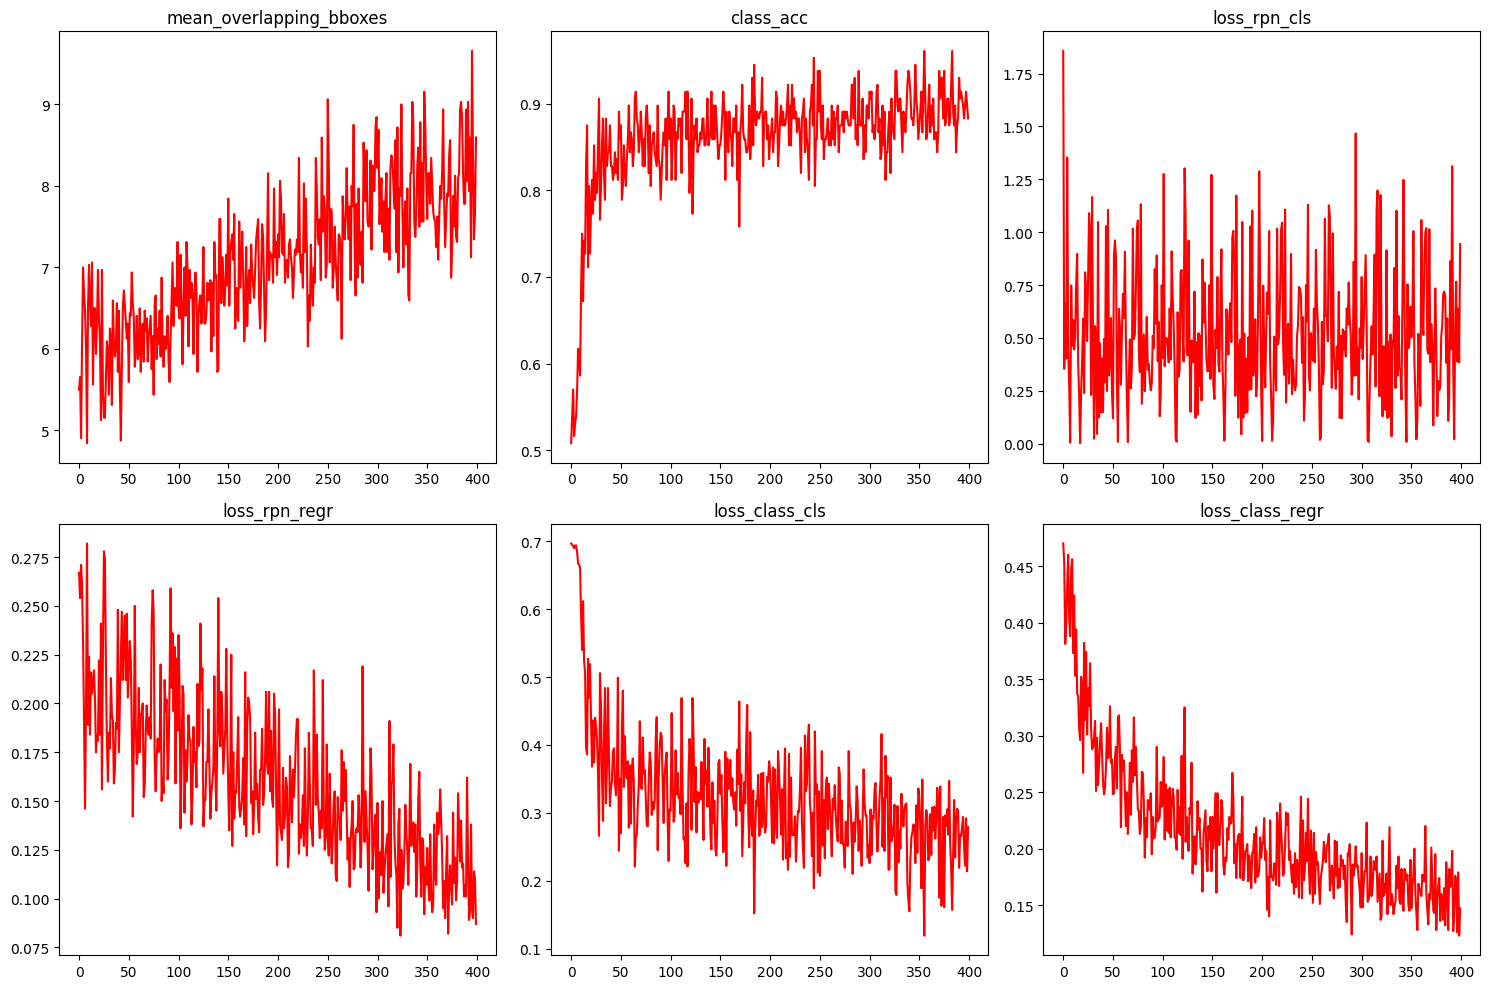

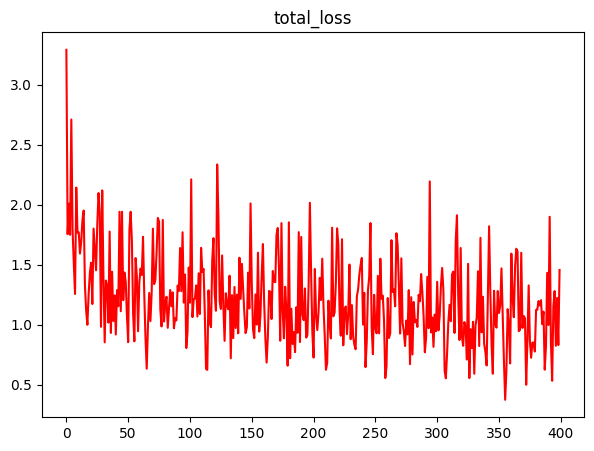

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Misalkan r_epochs adalah jumlah epoch yang direkam
r_epochs = len(record_df)

plt.figure(figsize=(15, 10))

# Plot mean_overlapping_bboxes
plt.subplot(2, 3, 1)
plt.plot(record_df['mean_overlapping_bboxes'], 'r')
plt.title('mean_overlapping_bboxes')

# Plot class_acc
plt.subplot(2, 3, 2)
plt.plot(record_df['class_acc'], 'r')
plt.title('class_acc')

# Plot loss_rpn_cls 
plt.subplot(2, 3, 3)
plt.plot(record_df['loss_rpn_cls'], 'r')
plt.title('loss_rpn_cls')

# Plot loss_rpn_regr
plt.subplot(2, 3, 4)
plt.plot(record_df['loss_rpn_regr'], 'r')
plt.title('loss_rpn_regr')

# Plot loss_class_cls
plt.subplot(2, 3, 5)
plt.plot(record_df['loss_class_cls'], 'r')
plt.title('loss_class_cls')

# Plot loss_class_regr
plt.subplot(2, 3, 6)
plt.plot(record_df['loss_class_regr'], 'r')
plt.title('loss_class_regr')

plt.tight_layout()
plt.show()

# Plot total_loss
plt.figure(figsize=(7, 5))
plt.plot(record_df['curr_loss'], 'r')
plt.title('total_loss')
plt.show()
